In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import matplotlib.pyplot as plt
import cv2

# Load model
model_path = "../eyenet_model_52k_ds.h5"
model = load_model(model_path)

print("Available layers in the model:")
for idx, layer in enumerate(model.layers):
    print(f"{idx}: {layer.name}")


Available layers in the model:
0: input_2
1: densenet121
2: global_average_pooling2d
3: dense
4: dense_1
5: reshape
6: multiply
7: tf.math.reduce_mean
8: tf.math.reduce_max
9: concatenate
10: conv2d
11: multiply_1
12: global_average_pooling2d_1
13: dense_2
14: dropout
15: dense_3


In [32]:
def generate_grad_cam(model, image, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(image)
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, tf.argmax(predictions[0])]

    # Compute gradients with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled gradients with the convolutional outputs
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [33]:
def overlay_heatmap(heatmap, original_image, alpha=0.4):
    """
    Overlays the heatmap on the original image.
    Args:
        heatmap: Grad-CAM heatmap.
        original_image: Original input image.
    Returns:
        Image with the overlayed heatmap.
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
    return overlay


In [34]:
def visualize_grad_cam(model, image_path, layer_name):
    # Load and preprocess the image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(original_image, (224, 224)) / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Convert image to TensorFlow tensor
    input_tensor = tf.convert_to_tensor(input_image)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(model, input_tensor, layer_name)

    # Overlay heatmap on the original image
    overlay = overlay_heatmap(heatmap, original_image)

    # Plot original image, heatmap, and overlay
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [59]:
def main():
    image_paths = [
        r"C:\Users\User\Desktop\ALL_DATA\Cataract_Test_Data\test5.jpg"
    ]

    # layers to show the flow through
    layer_name = 'multiply_3'

    for img_path in image_paths:
        print(f"🖼️ Processing: {img_path}")
        visualize_grad_cam(model, img_path, layer_name)

🖼️ Processing: C:\Users\User\Desktop\ALL_DATA\Cataract_Test_Data\test5.jpg


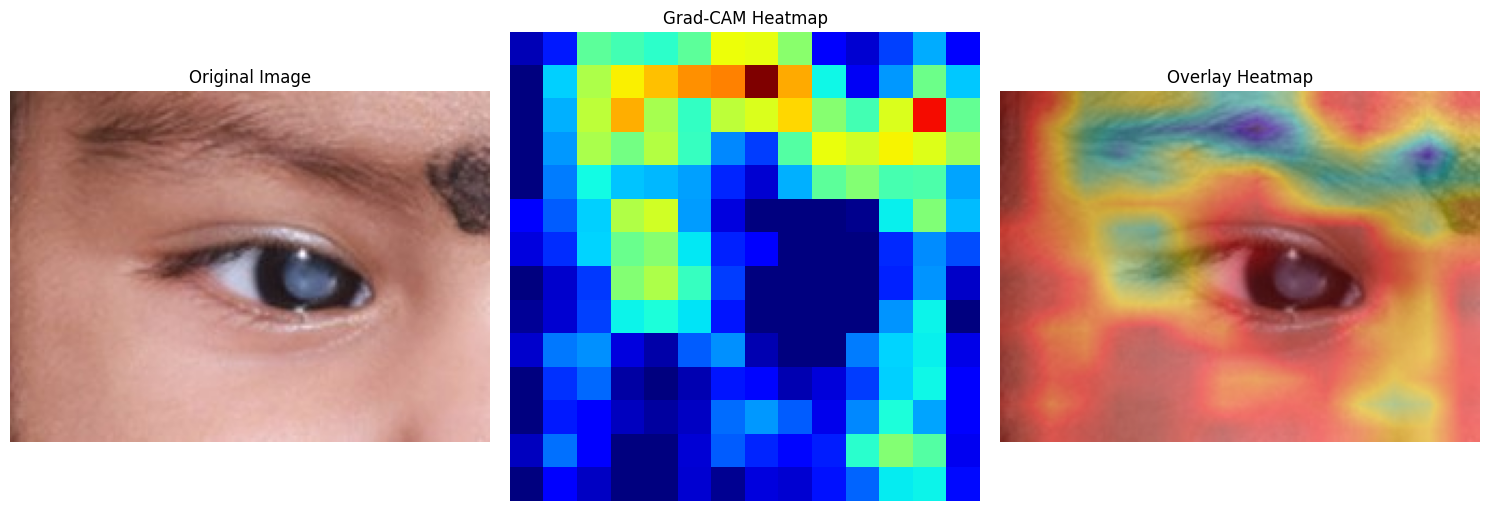

In [60]:
main()